**Assets (simple, standard, credible):**

**SPY –** US equities (growth & risk)

**AGG –** US aggregate bonds (rates & defense)

**GLD –** Gold (hedge)

**Weights (capital allocation):**

**SPY:** 60%

**AGG:** 30%

**GLD:**  10%

**Data frequency:** Daily

**Lookback:** 5 years

**Confidence levels:** 95% and 99%

In [1]:
pip install yfinance pandas numpy matplotlib scipy

In [3]:
#Step 2 — Pull data & compute returns

import yfinance as yf
import pandas as pd
import numpy as np

tickers = ["SPY", "AGG", "GLD"]
weights = np.array([0.6, 0.3, 0.1])

prices = yf.download(
    tickers,
    start="2020-01-01",
    auto_adjust=False
)["Adj Close"]
returns = prices.pct_change().dropna()

portfolio_returns = returns @ weights

[*********************100%***********************]  3 of 3 completed


In [4]:
#Step 3 — Core risk metrics

def annualized_vol(r):
    return np.std(r) * np.sqrt(252)

def var_historical(r, alpha=0.05):
    return np.percentile(r, 100 * alpha)

def cvar(r, alpha=0.05):
    var = var_historical(r, alpha)
    return r[r <= var].mean()

def max_drawdown(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = (cum - peak) / peak
    return dd.min()

baseline_metrics = {
    "Ann_Vol": annualized_vol(portfolio_returns),
    "VaR_95": var_historical(portfolio_returns, 0.05),
    "VaR_99": var_historical(portfolio_returns, 0.01),
    "CVaR_95": cvar(portfolio_returns, 0.05),
    "CVaR_99": cvar(portfolio_returns, 0.01),
    "Max_Drawdown": max_drawdown(portfolio_returns)
}

pd.DataFrame(baseline_metrics, index=["Baseline"])

,Ann_Vol,VaR_95,VaR_99,CVaR_95,CVaR_99,Max_Drawdown
Baseline,0.079268,-0.00735,-0.012294,-0.011038,-0.019253,-0.161345


In [9]:
#Step 4 — Scenario engine

#Define stress scenarios

shock_returns = returns.copy()

# Identify worst SPY return day
shock_day = shock_returns["SPY"].idxmin()

scenarios = {
    "Mild_Equity_Shock": shock_returns.assign(
        SPY=lambda x: x["SPY"].where(x.index != shock_day, x["SPY"] - 0.10)
    ),
    "Severe_Equity_Shock": shock_returns.assign(
        SPY=lambda x: x["SPY"].where(x.index != shock_day, x["SPY"] - 0.25)
    ),
    "Volatility_Spike": returns * 2
}


In [10]:
#Run scenarios
scenario_results = []

for name, scen_returns in scenarios.items():
    port_r = scen_returns @ weights
    scenario_results.append({
        "Scenario": name,
        "Ann_Vol": annualized_vol(port_r),
        "VaR_99": var_historical(port_r, 0.01),
        "CVaR_99": cvar(port_r, 0.01),
        "Max_Drawdown": max_drawdown(port_r)
    })

scenario_df = pd.DataFrame(scenario_results)
scenario_df

,Scenario,Ann_Vol,VaR_99,CVaR_99,Max_Drawdown
0,Mild_Equity_Shock,0.079469,-0.012568,-0.019379,-0.161345
1,Severe_Equity_Shock,0.080156,-0.012568,-0.020317,-0.161345
2,Volatility_Spike,0.158536,-0.024588,-0.038507,-0.304397


In [11]:
#Step 5 — Capital allocation insight
#Assume portfolio size = $10M

portfolio_value = 10_000_000

baseline_buffer = abs(baseline_metrics["CVaR_99"]) * portfolio_value
stress_buffer = abs(scenario_df["CVaR_99"].min()) * portfolio_value

baseline_buffer, stress_buffer


(np.float64(192533.82207255613), 385067.64414511225)

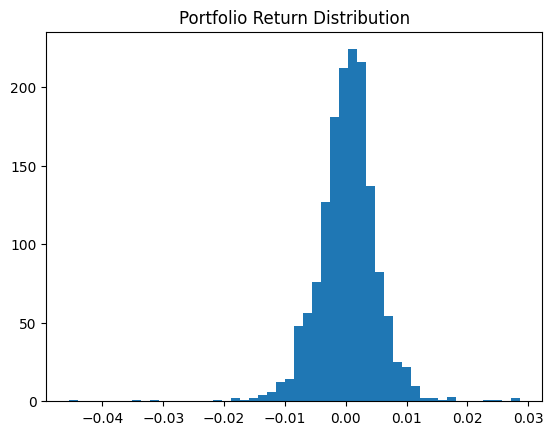

In [12]:
#Step 6 — Visuals

import matplotlib.pyplot as plt

plt.hist(portfolio_returns, bins=50)
plt.title("Portfolio Return Distribution")
plt.show()

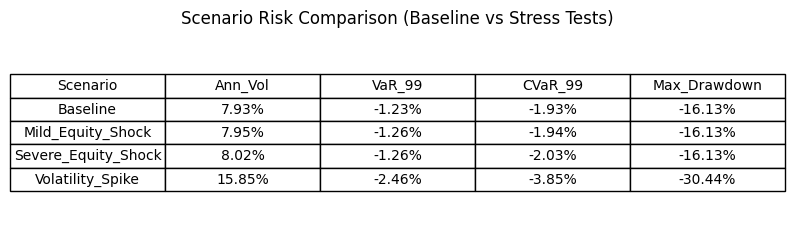

In [13]:
# --- Scenario Risk Comparison Table ---
import matplotlib.pyplot as plt

# scenario_df columns expected: Scenario, Ann_Vol, VaR_99, CVaR_99, Max_Drawdown

# Add Baseline row from baseline_metrics
baseline_row = {
    "Scenario": "Baseline",
    "Ann_Vol": baseline_metrics["Ann_Vol"],
    "VaR_99": baseline_metrics["VaR_99"],
    "CVaR_99": baseline_metrics["CVaR_99"],
    "Max_Drawdown": baseline_metrics["Max_Drawdown"],
}

scenario_table = pd.concat(
    [pd.DataFrame([baseline_row]), scenario_df],
    ignore_index=True
)

# Format as percents for display
display_table = scenario_table.copy()
for col in ["Ann_Vol", "VaR_99", "CVaR_99", "Max_Drawdown"]:
    display_table[col] = (display_table[col] * 100).map(lambda x: f"{x:.2f}%")

# Create a table-only figure (good for LinkedIn screenshot)
fig, ax = plt.subplots(figsize=(10, 2.4))
ax.axis("off")

tbl = ax.table(
    cellText=display_table.values,
    colLabels=display_table.columns,
    cellLoc="center",
    loc="center"
)

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.4)

plt.title("Scenario Risk Comparison (Baseline vs Stress Tests)", pad=12)
plt.show()

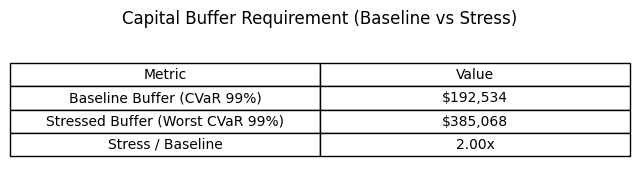

In [14]:
#Capital Buffer Summary

import pandas as pd
import matplotlib.pyplot as plt

# Assumes baseline_metrics, scenario_df, and portfolio_value already exist
portfolio_value = 10_000_000

baseline_buffer = abs(baseline_metrics["CVaR_99"]) * portfolio_value
stress_buffer = abs(scenario_df["CVaR_99"].min()) * portfolio_value

buffer_df = pd.DataFrame({
    "Metric": ["Baseline Buffer (CVaR 99%)", "Stressed Buffer (Worst CVaR 99%)", "Stress / Baseline"],
    "Value": [f"${baseline_buffer:,.0f}", f"${stress_buffer:,.0f}", f"{stress_buffer / baseline_buffer:.2f}x"]
})

fig, ax = plt.subplots(figsize=(8, 1.8))
ax.axis("off")
tbl = ax.table(cellText=buffer_df.values, colLabels=buffer_df.columns, cellLoc="center", loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.4)

plt.title("Capital Buffer Requirement (Baseline vs Stress)", pad=12)
plt.show()

fig.savefig("capital_buffer_summary.png", dpi=200, bbox_inches="tight")